In [434]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, LabelEncoder

df = pd.read_csv('./data/loan.csv')

In [435]:
# Non numeric columns for transforming the data
non_num_cols = []
num_cols = []

non_num_cols.extend(df.select_dtypes('object').columns.to_list())
non_num_cols.extend(df.select_dtypes('bool').columns.to_list())

num_cols.extend(df.select_dtypes(np.number).columns.to_list())

## Data Cleaning

### Null Values

In [436]:
df.isnull().sum()

loanId                                 256
anon_ssn                                 0
payFrequency                          1273
apr                                   3922
applicationDate                          0
originated                               0
originatedDate                      531638
nPaidOff                                24
approved                                 0
isFunded                                 0
loanStatus                             391
loanAmount                            2250
originallyScheduledPaymentAmount         0
state                                  132
leadType                                 0
leadCost                                 0
fpStatus                            525959
clarityFraudId                      219989
hasCF                                    0
dtype: int64

In [437]:
# Drop unnecessary columns
df = df.drop(columns = ['loanId', 'originatedDate', 'fpStatus', 'clarityFraudId'])

In [438]:
# Replace with most frequent value (300k rows with same value)
df['payFrequency'] = df['payFrequency'].fillna('B')

In [439]:
# Replace with most frequent value (200k rows with same value)
df['apr'] = df['apr'].fillna(590.0)

In [440]:
# Replace with most frequent value (500k rows with same value)
df['nPaidOff'] = df['nPaidOff'].fillna(0.0)

In [441]:
# Replace with average of top three most frequent value
replacement_val = (500 + 400 + 350) / 3
df['loanAmount'] = df['loanAmount'].fillna(replacement_val)

In [442]:
# Replace with most frequent value (90k rows with same value)
df['state'] = df['state'].fillna('OH')

In [443]:
df = df.dropna()

In [444]:
df.shape

(577291, 15)

In [445]:
df.isnull().sum()

anon_ssn                            0
payFrequency                        0
apr                                 0
applicationDate                     0
originated                          0
nPaidOff                            0
approved                            0
isFunded                            0
loanStatus                          0
loanAmount                          0
originallyScheduledPaymentAmount    0
state                               0
leadType                            0
leadCost                            0
hasCF                               0
dtype: int64

### Outliers

In [446]:
df.shape

(577291, 15)

In [447]:
df.dtypes

anon_ssn                             object
payFrequency                         object
apr                                 float64
applicationDate                      object
originated                             bool
nPaidOff                            float64
approved                               bool
isFunded                              int64
loanStatus                           object
loanAmount                          float64
originallyScheduledPaymentAmount    float64
state                                object
leadType                             object
leadCost                              int64
hasCF                                 int64
dtype: object

#### Loan Amount

<Axes: ylabel='loanAmount'>

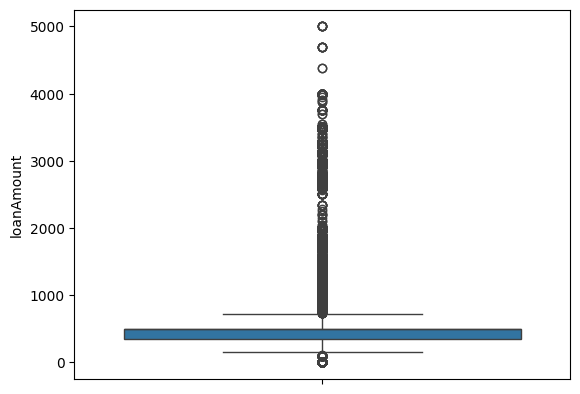

In [448]:
sns.boxplot(df['loanAmount'])

In [449]:
# Calculating Lower bound and Higher bound for outlier removal
Q1 = df['loanAmount'].quantile(0.25)
Q3 = df['loanAmount'].quantile(0.75)
IQR = Q3 - Q1

low_bound = Q1 - 1.5 * IQR
up_bound = Q3 + 1.5 * IQR

tbd_datapoints = df[(df['loanAmount'] < low_bound) | (df['loanAmount'] > up_bound)]
print("Number of datapoints to be deleted: " + str(tbd_datapoints.shape[0]))

Number of datapoints to be deleted: 59314


In [450]:
# Removing outliers
df = df[(df['loanAmount'] > low_bound) & (df['loanAmount'] < up_bound)]

<Axes: ylabel='loanAmount'>

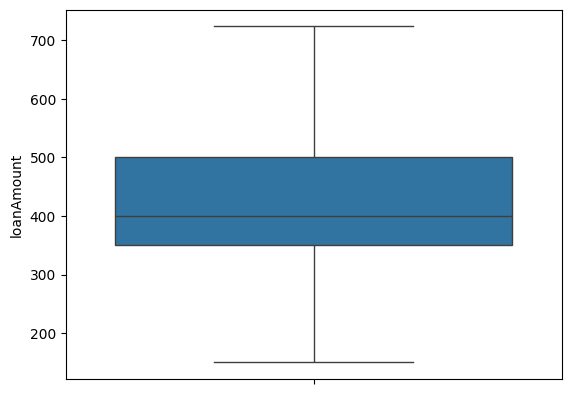

In [451]:
sns.boxplot(df['loanAmount'])

#### Originally Scheduled Payment Amount

<Axes: ylabel='originallyScheduledPaymentAmount'>

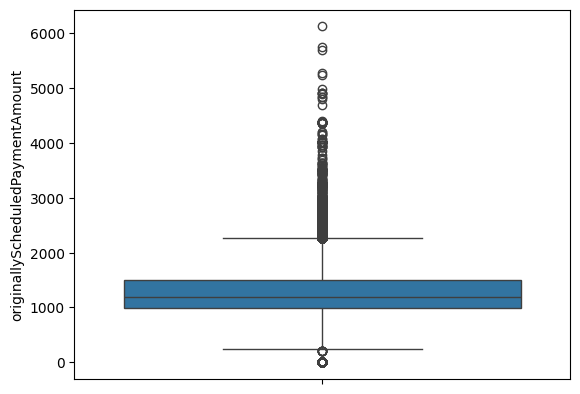

In [452]:
sns.boxplot(df['originallyScheduledPaymentAmount'])

In [453]:
# Calculating Lower bound and Higher bound for outlier removal
Q1 = df['originallyScheduledPaymentAmount'].quantile(0.25)
Q3 = df['originallyScheduledPaymentAmount'].quantile(0.75)
IQR = Q3 - Q1

low_bound = Q1 - 1.5 * IQR
up_bound = Q3 + 1.5 * IQR

tbd_datapoints = df[(df['originallyScheduledPaymentAmount'] < low_bound) | (df['originallyScheduledPaymentAmount'] > up_bound)]
print("Number of datapoints to be deleted: " + str(tbd_datapoints.shape[0]))

Number of datapoints to be deleted: 12242


In [454]:
# Removing outliers
df = df[(df['originallyScheduledPaymentAmount'] > low_bound) & (df['originallyScheduledPaymentAmount'] < up_bound)]

<Axes: ylabel='originallyScheduledPaymentAmount'>

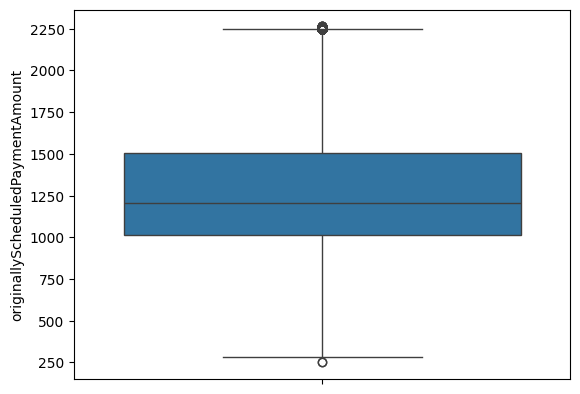

In [455]:
sns.boxplot(df['originallyScheduledPaymentAmount'])

#### Annual Percent Rate (apr)

<Axes: ylabel='apr'>

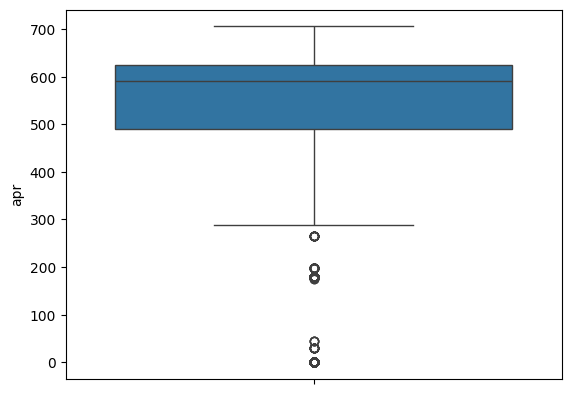

In [456]:
sns.boxplot(df['apr'])

In [457]:
# Calculating Lower bound and Higher bound for outlier removal
Q1 = df['apr'].quantile(0.25)
Q3 = df['apr'].quantile(0.75)
IQR = Q3 - Q1

low_bound = Q1 - 1.5 * IQR
up_bound = Q3 + 1.5 * IQR

tbd_datapoints = df[(df['apr'] < low_bound) | (df['apr'] > up_bound)]
print("Number of datapoints to be deleted: " + str(tbd_datapoints.shape[0]))

Number of datapoints to be deleted: 3787


In [458]:
# Removing outliers
df = df[(df['apr'] > low_bound) & (df['apr'] < up_bound)]

<Axes: ylabel='apr'>

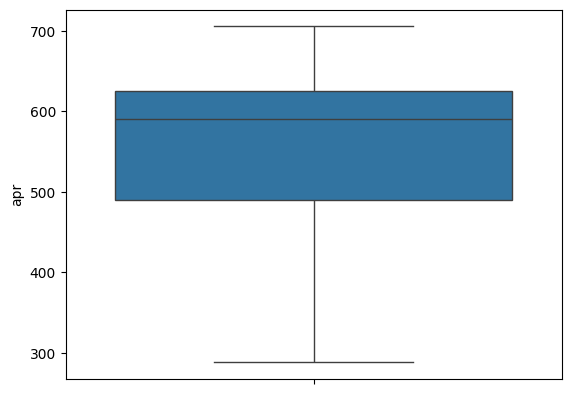

In [459]:
sns.boxplot(df['apr'])

In [460]:
print("Final shape of the dataframe after removing outliers:")
df.shape

Final shape of the dataframe after removing outliers:


(501948, 15)

### Feature Engineering

In [461]:
# Extract year and month data from Application Date
df['applicationYear'] = pd.DatetimeIndex(df['applicationDate']).year
df['applicationMonth'] = pd.DatetimeIndex(df['applicationDate']).month
df = df.drop(columns = ['applicationDate'])

In [462]:
# Ratio between loan amount and lead cost
df['leadCost-loanAm-ratio'] = df['leadCost'] / df['loanAmount']

num_cols.append('leadCost-loanAm-ratio')

#### Online Source for Seasonal Data in USA

- Winter is considered December, January and February;
- Spring is March through May;
- Summer is June through August;
- Fall or autumn is September through November.

In [463]:
# Extracting seasonal data from months

month_to_season = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

df['season'] = df['applicationMonth'].map(month_to_season)

non_num_cols.append('season')

### Target Variable

- Converting target variable to a binary value column of high risk and low risk

In [464]:
high_risk = ['Rejected' , 'External Collection' , 'Internal Collection' , 'Charged Off' , 'Settled Bankruptcy']

binaryRiskStatus = ['High' if x in high_risk else 'Low' for x in df['loanStatus']]
df['binaryRiskStatus'] = binaryRiskStatus

df = df.drop(columns = ['loanStatus'])

non_num_cols.append('binaryRiskStatus')

### Encoding Categorical Values

In [465]:
df.dtypes

anon_ssn                             object
payFrequency                         object
apr                                 float64
originated                             bool
nPaidOff                            float64
approved                               bool
isFunded                              int64
loanAmount                          float64
originallyScheduledPaymentAmount    float64
state                                object
leadType                             object
leadCost                              int64
hasCF                                 int64
applicationYear                       int32
applicationMonth                      int32
leadCost-loanAm-ratio               float64
season                               object
binaryRiskStatus                     object
dtype: object

- Need to encode only 'payFrequency' for ordinal encoding
- The rest of the categorical columns will use label encoder

In [466]:
# Ordinal encoding of 'payFrequency' column
encoding_mapping = {'I': 0, 'S': 1, 'M': 2, 'B': 3, 'W': 4}

ordinal_encoder = OrdinalEncoder(categories=[sorted(encoding_mapping, key=encoding_mapping.get)])
encoded_data = ordinal_encoder.fit_transform(df[['payFrequency']])

df = df.drop(columns = ['payFrequency'])
df['payFrequency'] = encoded_data

In [467]:
# Using label encoder on all the categorical variables of the dataframe
label_encoder = LabelEncoder()

for col in df.columns:
    if col in non_num_cols:
        df[col] = label_encoder.fit_transform(df[col])
    else:
        df[col] = df[col]

### Scaling Numerical Values

In [468]:
df.dtypes

anon_ssn                              int64
apr                                 float64
originated                            int64
nPaidOff                            float64
approved                              int64
isFunded                              int64
loanAmount                          float64
originallyScheduledPaymentAmount    float64
state                                 int64
leadType                              int64
leadCost                              int64
hasCF                                 int64
applicationYear                       int32
applicationMonth                      int32
leadCost-loanAm-ratio               float64
season                                int64
binaryRiskStatus                      int64
payFrequency                          int64
dtype: object

(array([1.30000e+01, 2.76200e+03, 2.80000e+01, 8.56000e+02, 2.10000e+01,
        6.09740e+04, 8.81550e+04, 6.03800e+03, 1.17378e+05, 2.50000e+01,
        1.26600e+03, 7.40000e+01, 1.54242e+05, 1.15500e+03, 2.80000e+01,
        5.67960e+04, 3.52000e+02, 9.45000e+02, 2.70000e+01, 1.08130e+04]),
 array([150.  , 178.65, 207.3 , 235.95, 264.6 , 293.25, 321.9 , 350.55,
        379.2 , 407.85, 436.5 , 465.15, 493.8 , 522.45, 551.1 , 579.75,
        608.4 , 637.05, 665.7 , 694.35, 723.  ]),
 <BarContainer object of 20 artists>)

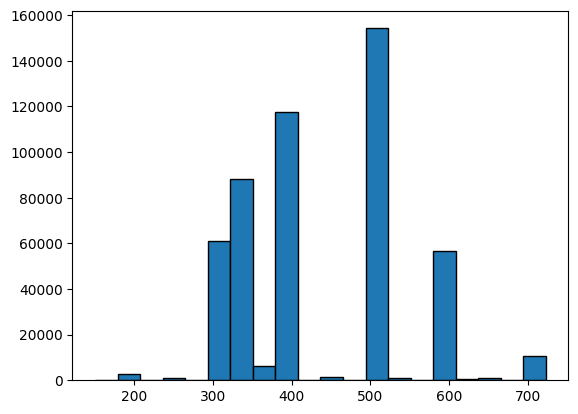

In [469]:
plt.hist(df['loanAmount'], edgecolor='black', bins=20)

(array([4.84000e+02, 5.69000e+02, 1.30000e+01, 6.61620e+04, 6.09800e+03,
        2.32000e+02, 8.60000e+01, 2.57650e+04, 3.10400e+03, 2.58360e+04,
        1.34100e+03, 4.06900e+03, 1.55900e+03, 4.36000e+02, 2.38963e+05,
        1.80000e+01, 1.31390e+04, 6.58710e+04, 4.81960e+04, 7.00000e+00]),
 array([288.    , 308.8795, 329.759 , 350.6385, 371.518 , 392.3975,
        413.277 , 434.1565, 455.036 , 475.9155, 496.795 , 517.6745,
        538.554 , 559.4335, 580.313 , 601.1925, 622.072 , 642.9515,
        663.831 , 684.7105, 705.59  ]),
 <BarContainer object of 20 artists>)

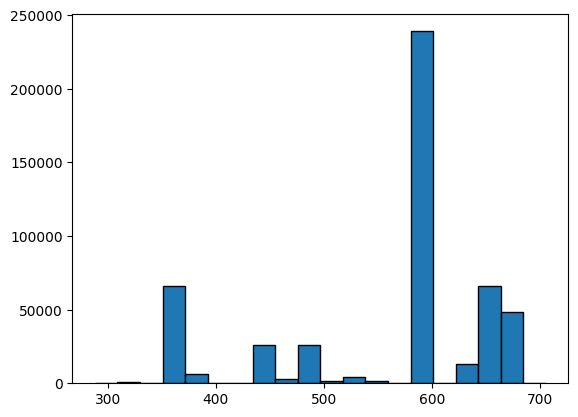

In [470]:
plt.hist(df['apr'], edgecolor='black', bins=20)

(array([  379.,   915.,  3093., 13941., 22282., 24749., 31910., 53524.,
        71500., 55653., 44058., 36647., 32682., 36198., 25195., 24780.,
        11977.,  4772.,  4771.,  2922.]),
 array([ 250.   ,  350.724,  451.448,  552.172,  652.896,  753.62 ,
         854.344,  955.068, 1055.792, 1156.516, 1257.24 , 1357.964,
        1458.688, 1559.412, 1660.136, 1760.86 , 1861.584, 1962.308,
        2063.032, 2163.756, 2264.48 ]),
 <BarContainer object of 20 artists>)

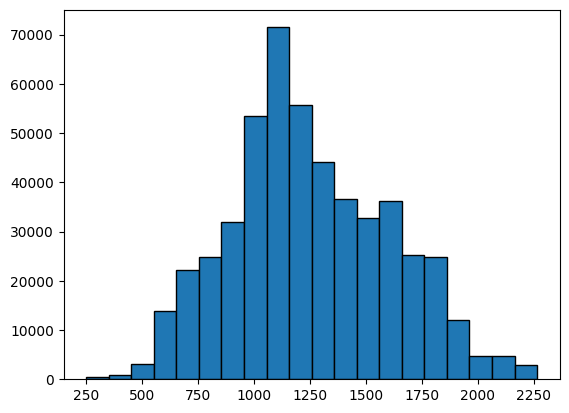

In [471]:
plt.hist(df['originallyScheduledPaymentAmount'], edgecolor='black', bins=20)

In [472]:

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['loanAmount']])
df['loanAmount'] = scaled_data

scaled_data = scaler.fit_transform(df[['apr']])
df['apr'] = scaled_data

scaled_data = scaler.fit_transform(df[['originallyScheduledPaymentAmount']])
df['originallyScheduledPaymentAmount'] = scaled_data

scaled_data = scaler.fit_transform(df[['anon_ssn']])
df['anon_ssn'] = scaled_data

In [473]:
df.head(5)

,anon_ssn,apr,originated,nPaidOff,approved,isFunded,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,hasCF,applicationYear,applicationMonth,leadCost-loanAm-ratio,season,binaryRiskStatus,payFrequency
0,0.746101,0.172418,0,0.0,0,0,0.61082,0.361518,10,0,6,1,2016,2,0.012000,3,1,3
2,0.235340,0.723197,0,0.0,0,0,0.43630,0.471313,17,0,3,1,2016,8,0.007500,2,1,3
3,0.608820,0.172418,0,0.0,0,0,0.61082,0.409063,10,0,3,1,2015,8,0.006000,2,1,3
4,0.390076,0.723197,0,0.0,0,0,0.34904,0.280157,24,0,3,1,2016,6,0.008571,2,0,3
5,0.707906,0.866879,0,0.0,0,0,0.26178,0.242335,11,4,0,1,2016,6,0.000000,2,1,2


### Saving as Pickle File

In [474]:
with open('data/data.pickle', 'wb') as file:
    pickle.dump(df, file, protocol=pickle.HIGHEST_PROTOCOL)

## Exploratory Data Analysis

In [475]:
df.dtypes

anon_ssn                            float64
apr                                 float64
originated                            int64
nPaidOff                            float64
approved                              int64
isFunded                              int64
loanAmount                          float64
originallyScheduledPaymentAmount    float64
state                                 int64
leadType                              int64
leadCost                              int64
hasCF                                 int64
applicationYear                       int32
applicationMonth                      int32
leadCost-loanAm-ratio               float64
season                                int64
binaryRiskStatus                      int64
payFrequency                          int64
dtype: object

In [476]:
# Changing the datatypes suitably

non_num_cols = ['anon_ssn', 'originated', 'nPaidOff', 'approved', 'isFunded', 'state', 
            'leadType', 'hasCF', 'applicationYear', 'applicationMonth', 'season', 
            'binaryRiskStatus', 'payFrequency']

for col in non_num_cols:
    df[col] = df[col].astype(str)

#### Checking for inconsistencies by looking at overview of data

In [477]:
df.describe(include=np.number)

,apr,loanAmount,originallyScheduledPaymentAmount,leadCost,leadCost-loanAm-ratio
count,501948.000000,501948.000000,501948.000000,501948.000000,501948.000000
mean,0.652032,0.502712,0.497383,6.893342,0.015816
std,0.235535,0.176860,0.176753,10.158932,0.021458
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.483728,0.349040,0.381622,3.000000,0.007500
50%,0.723197,0.436300,0.473939,3.000000,0.010000
75%,0.807012,0.610820,0.625402,6.000000,0.015000
max,1.000000,1.000000,1.000000,200.000000,0.800000


In [478]:
df.describe(exclude=np.number)

,anon_ssn,originated,nPaidOff,approved,isFunded,state,leadType,hasCF,applicationYear,applicationMonth,season,binaryRiskStatus,payFrequency
count,501948,501948,501948,501948,501948,501948,501948,501948,501948,501948,501948,501948,501948
unique,405155,2,20,2,2,40,8,2,4,12,4,2,5
top,0.7842277257536641,0,0.0,0,0,25,0,1,2016,1,3,1,3
freq,21,467534,493764,472179,472969,81885,435923,295652,276027,88448,221969,412418,275873


#### Analyzing the correlation of all the columns

<Axes: >

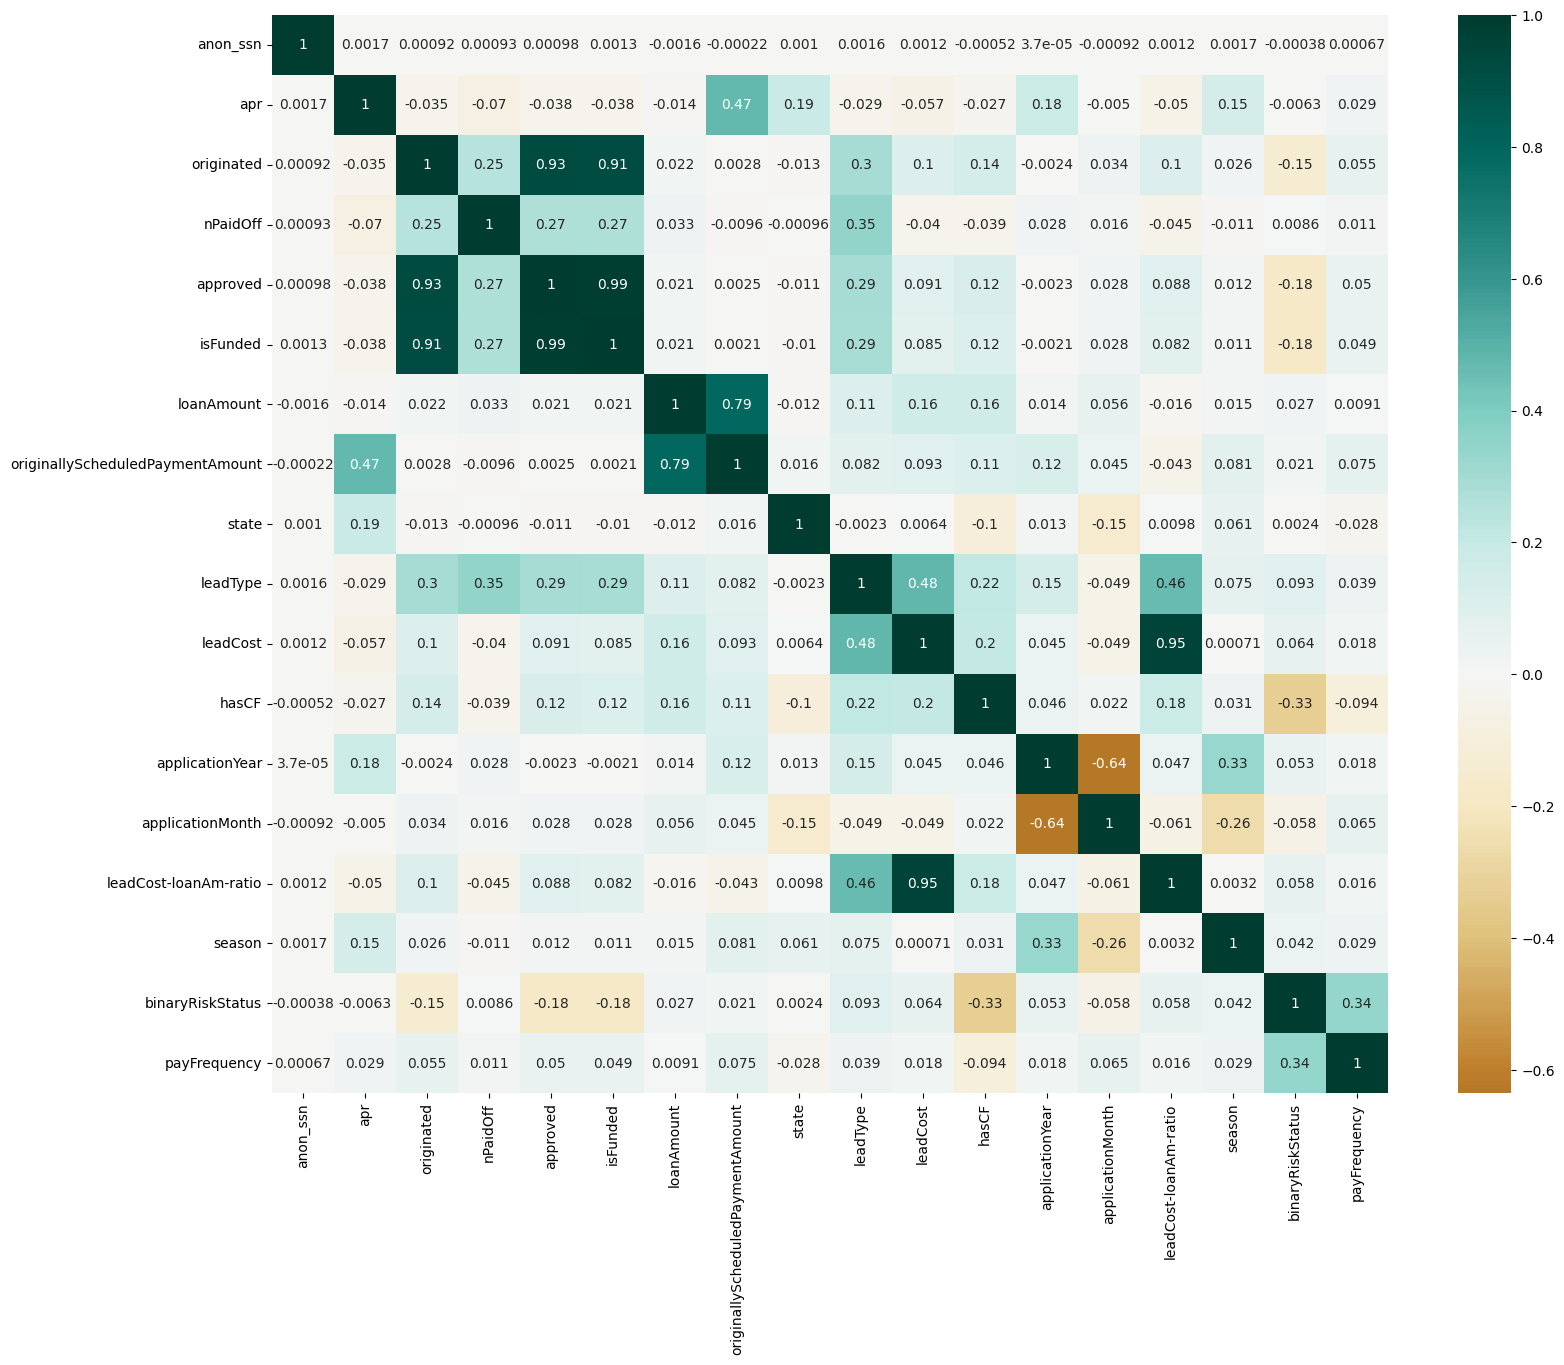

In [479]:
fig, ax = plt.subplots(figsize=(18,14))
sns.heatmap(df.corr(), center = 0, cmap='BrBG', annot=True)

- The dataset has very low correlation. 
- Need to use non-linear solutions and boosting methods. 
- Suggested LightBGM model is one of the best solutions for a dataset like this. 
- This is because it does boosting and uses decision trees as base learners.

#### Frequency Analysis

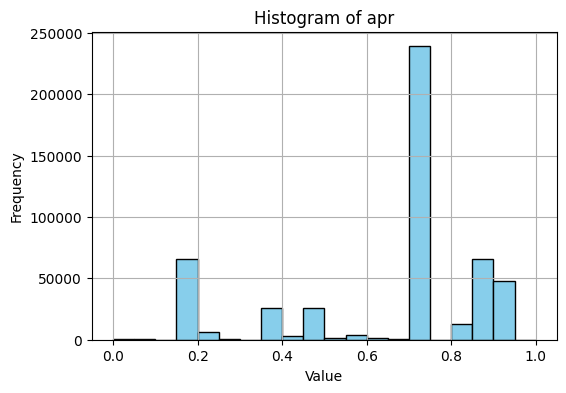

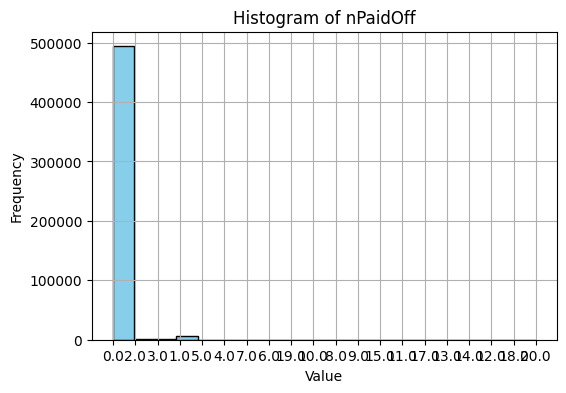

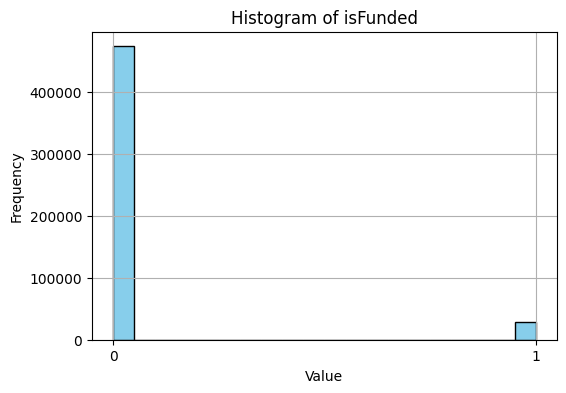

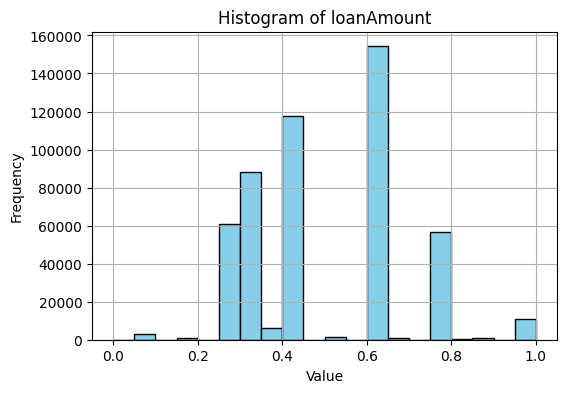

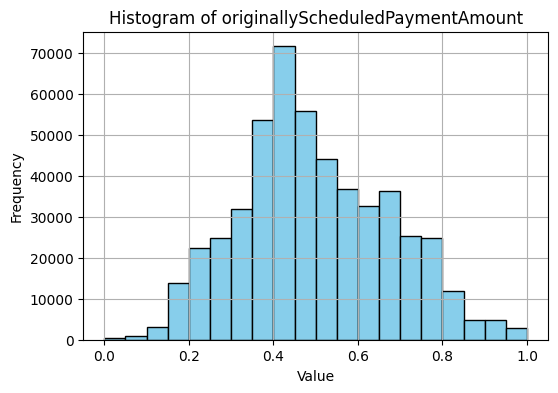

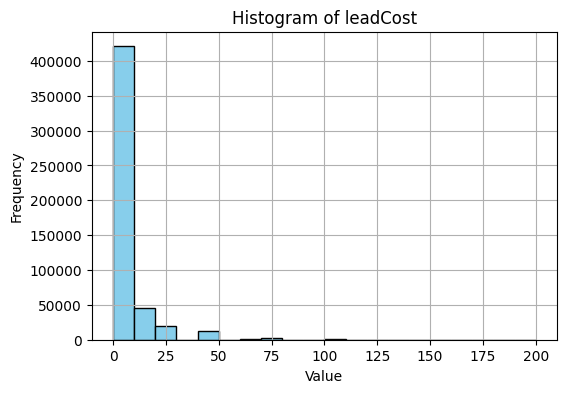

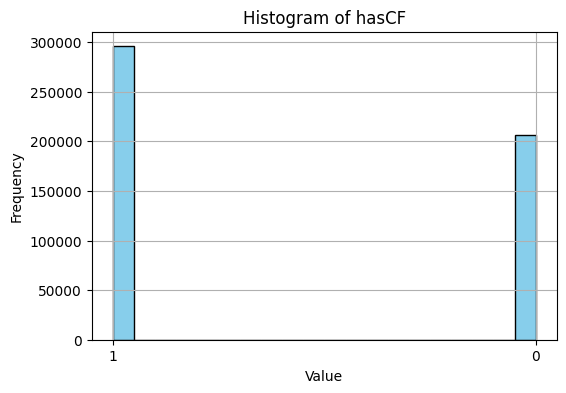

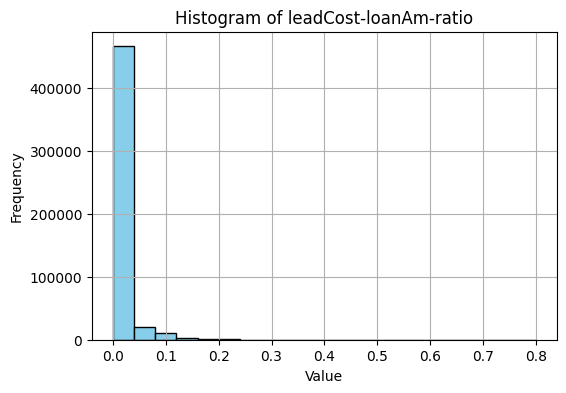

In [480]:
# Plotting histograms for each column
for column in num_cols:
    plt.figure(figsize=(6, 4))
    plt.hist(df[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

- Most of the numerical values do not have a normal distribution.
- This is a downside for machine learning models.

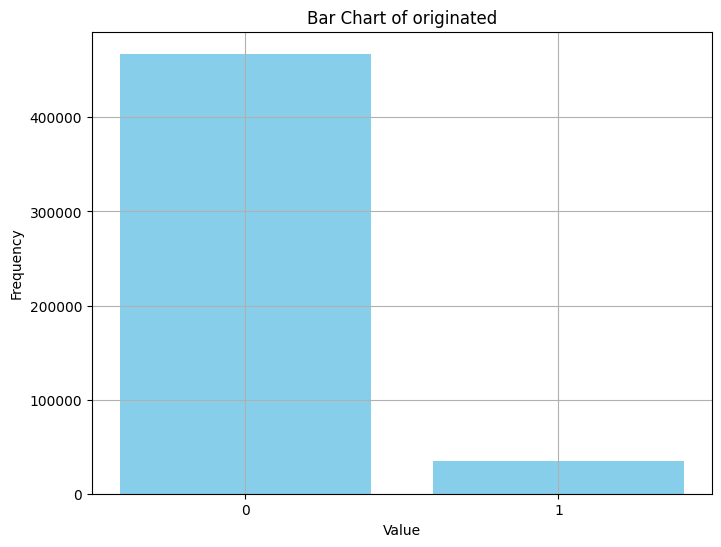

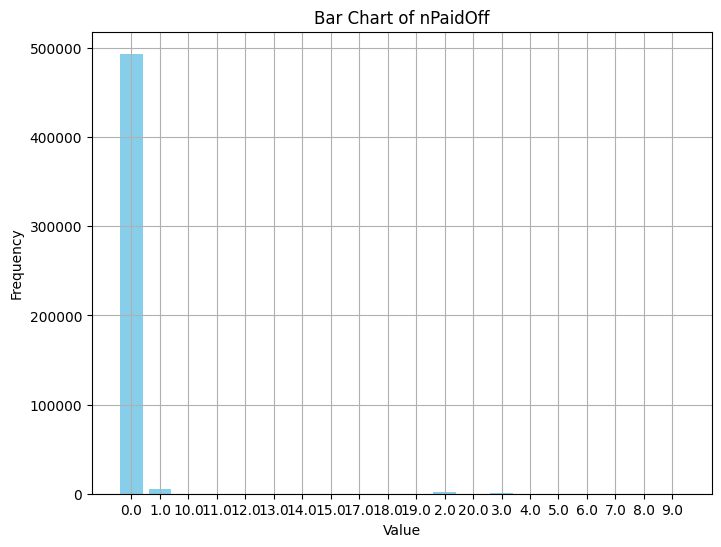

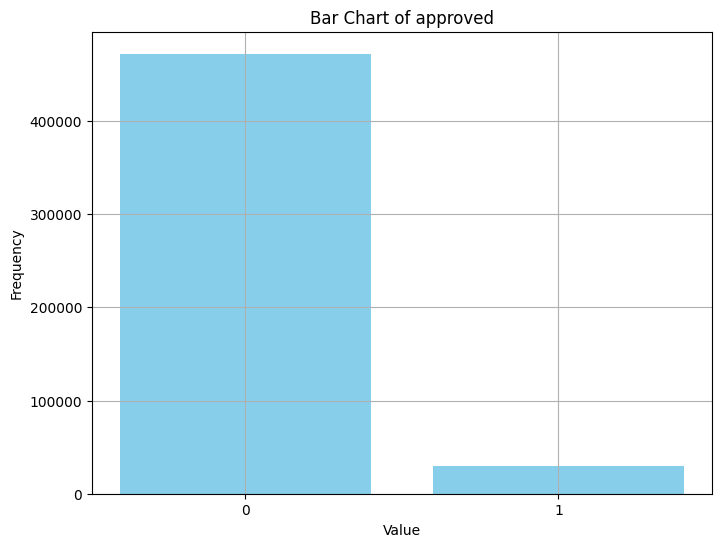

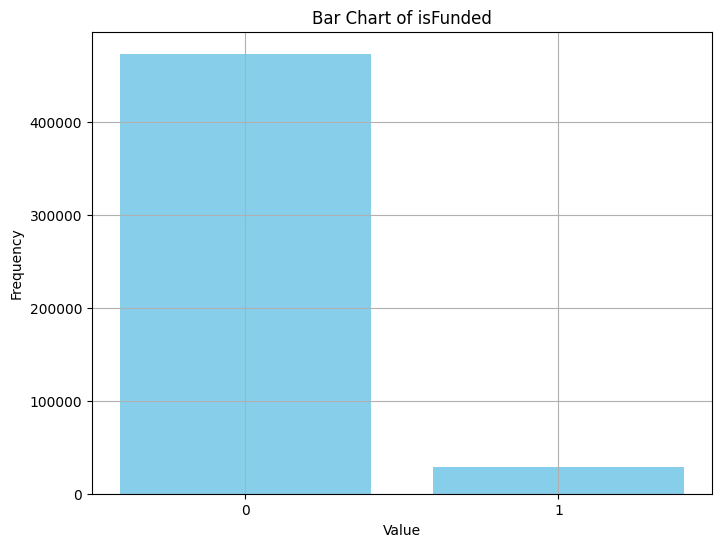

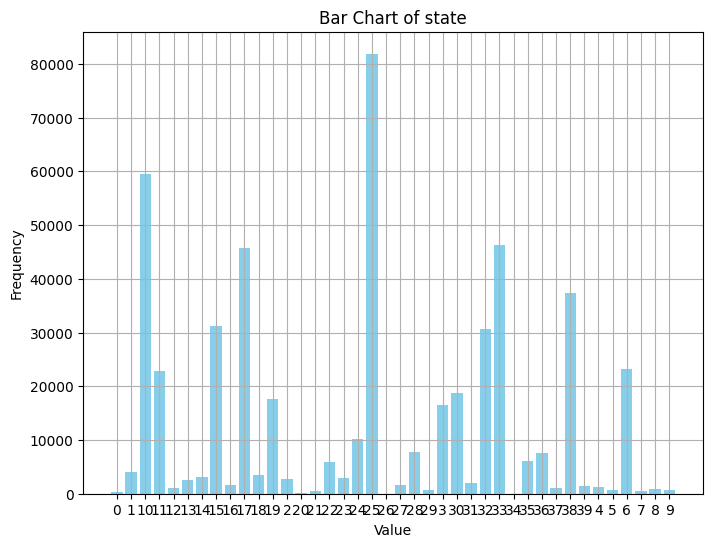

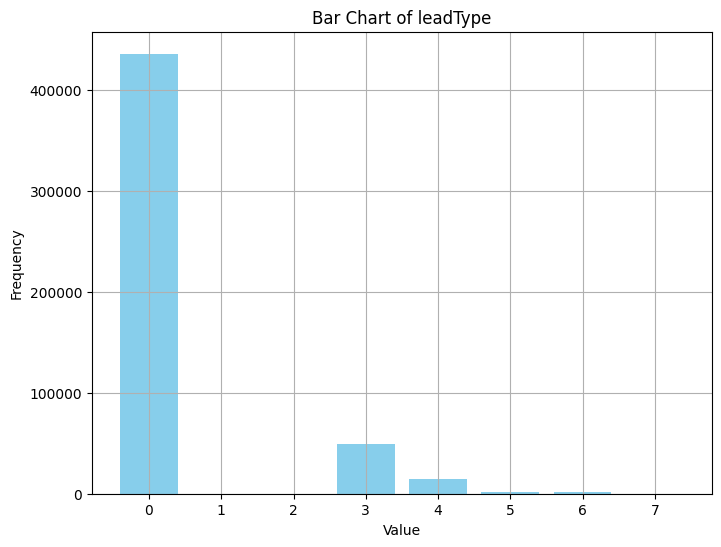

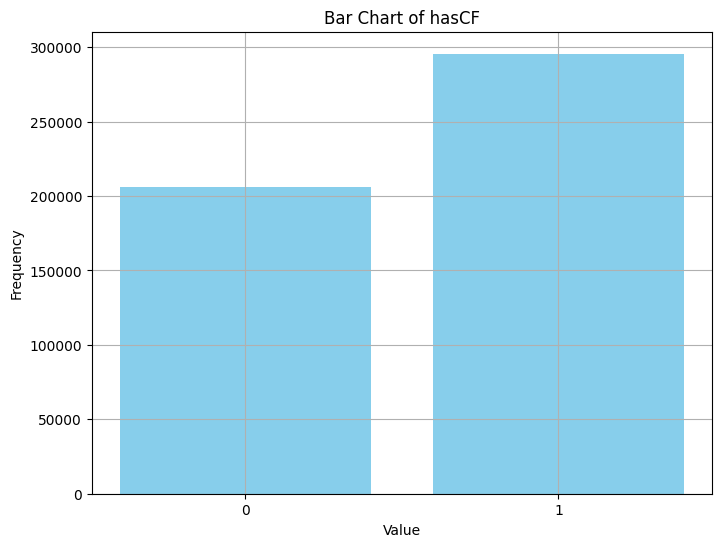

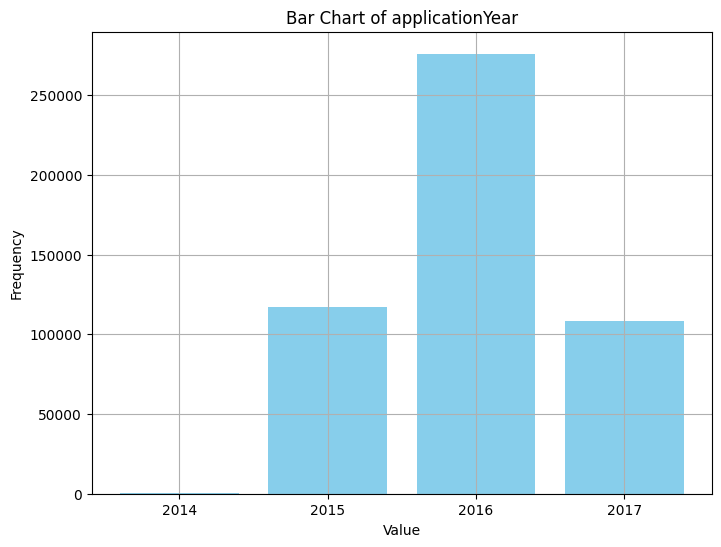

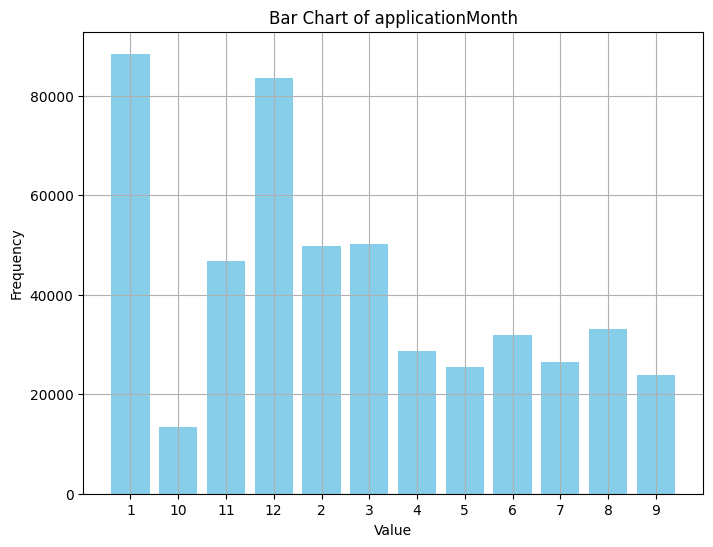

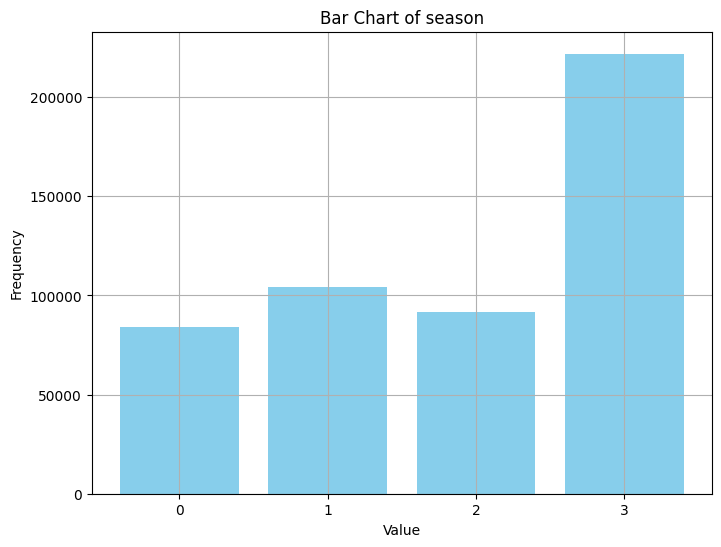

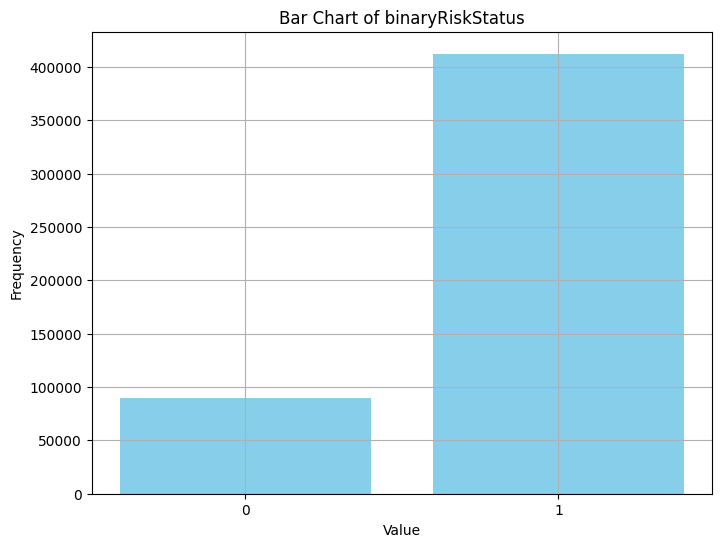

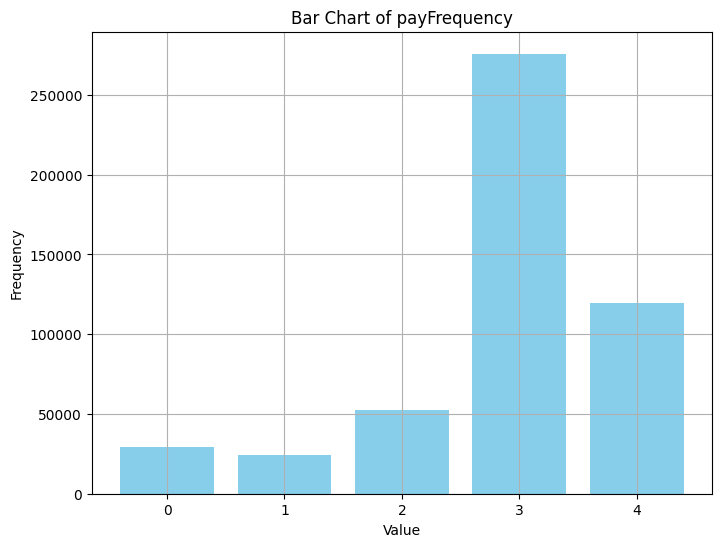

In [481]:
# Plotting bar charts for each column
bar_cols = non_num_cols.copy()
bar_cols.remove('anon_ssn')

for column in bar_cols:
    plt.figure(figsize=(8, 6))
    value_counts = df[column].value_counts().sort_index()
    values = list(value_counts.index)
    counts = list(value_counts.values)
    plt.bar(values, counts, color='skyblue')
    plt.title(f'Bar Chart of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

- Most of the categorical variables are not balanced
- Could be handled internally by LightBGM
- If not handled well, this is a point of improvement later

#### Pairplots

/home/abhaydhanthi/.pyenv/versions/3.12.2/envs/playground/lib/python3.12/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


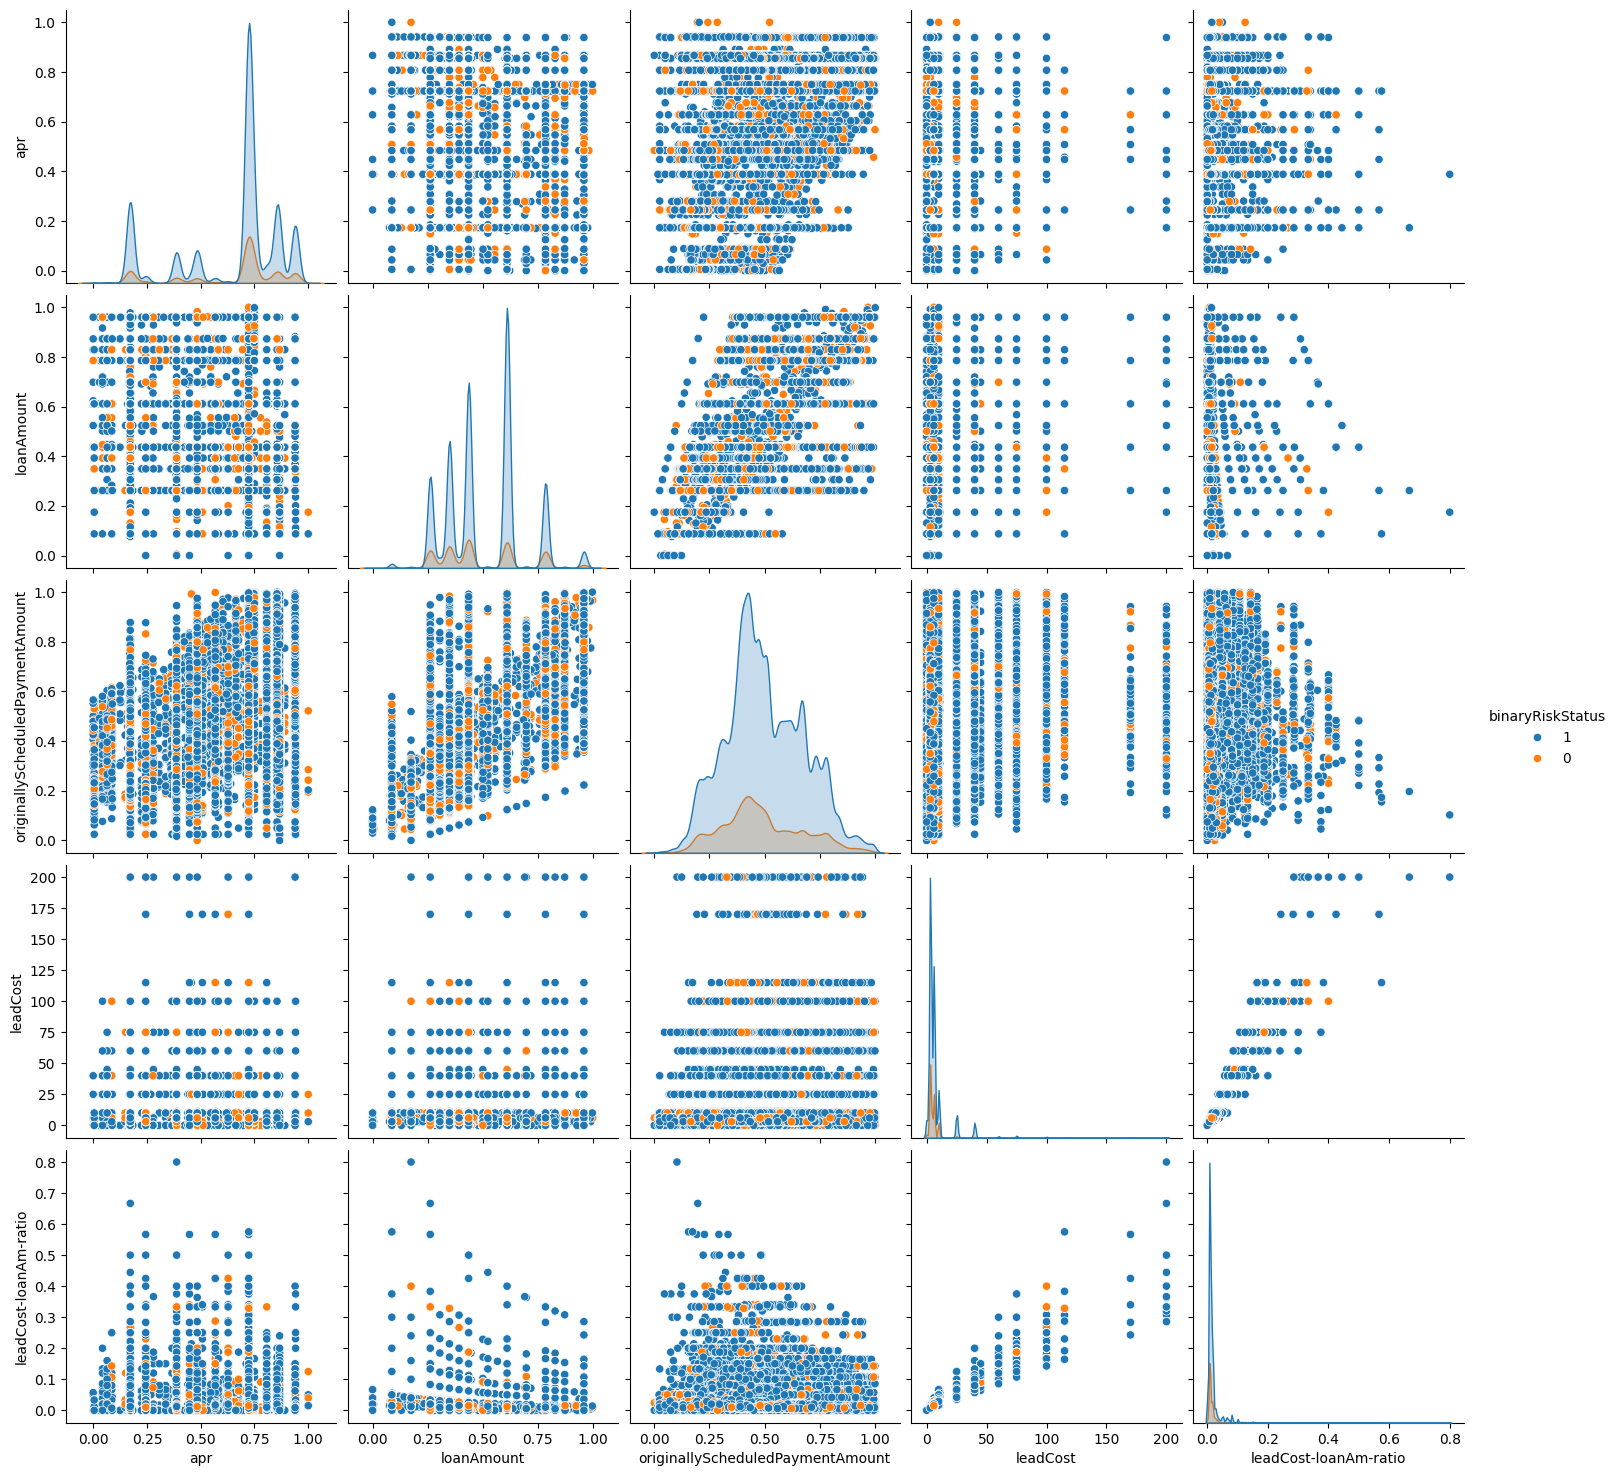

In [482]:
sns.pairplot(df, hue='binaryRiskStatus', size=3)